In [ ]:
!pip install kagglehub

GET AND CHECK DATA

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("darshue/extracted-images")

print("Path to dataset files:", path)

100%|██████████| 3.40G/3.40G [00:33<00:00, 108MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/darshue/extracted-images/versions/19


If you're training the model using colab use the bottom  command to install the datasets. You'll need your kaggle api key which you can generate in your account settings at kaggle. Download the api key and paste the key when prompted to download the dataset

In [ ]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/darshue/extracted-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abielkim
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/darshue/extracted-images


The code below checks if youre dataset has been installed at the correct path

In [ ]:
import os

is_colab = True
if is_colab:
    data_dir = './extracted-images/train/'
else:
    data_dir = "../data/train/"


print("Path exists:", os.path.exists(data_dir))  # Should print True
print("Contents:", os.listdir(data_dir))  # Should list the 5 subclasses

output_dir = '../output'
os.makedirs(output_dir, exist_ok=True)

Path exists: True
Contents: ['LGSC', 'CC', 'MC', 'HGSC', 'EC']


IMPORTS AND DEVICE

In [ ]:
import torch
import os
import os.path
import numpy as np
import sys
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.datasets as datasets
import seaborn as sns
from sklearn.metrics import confusion_matrix

np.random.seed(111)
torch.manual_seed(111)
torch.cuda.manual_seed_all(111)

In [ ]:
if torch.cuda.is_available():
    print("CUDA available")
    device = torch.device("cuda")
else:
    print("CUDA not available")
    device = torch.device("cpu")
print("Device: ", device)

CUDA available
Device:  cuda


In [ ]:
train_test_split = 0.8
batch_size = 32
num_epochs = 10
learning_rate = 0.001
num_classes = 5
if is_colab:
    num_workers = 4
else:
    num_workers = 1


In [ ]:
# mean, std = [0.7276], [0.1001]

# mean=[0.8078, 0.6699, 0.8137]
# std=[0.0925, 0.1143, 0.0710]

mean = [0.8078, 0.6700, 0.8138]
std = [0.0925, 0.1142, 0.0710]

In [ ]:
train_transform = transforms.Compose([
    #transforms.Grayscale(num_output_channels=1),
    transforms.Resize((496, 496)),
    transforms.RandomCrop(480),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_transform = transforms.Compose([
    #transforms.Grayscale(num_output_channels=1),
    transforms.Resize((496, 496)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [ ]:
# train_dataset = datasets.ImageFolder(root=os.path.join(data_dir), transform=train_transform)
# test_dataset = datasets.ImageFolder(root=os.path.join(data_dir), transform=test_transform)

# train_size = int(train_test_split * len(train_dataset))
# test_size = len(train_dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# print('Number of training samples:', len(train_loader.dataset))
# print('Number of testing samples:', len(test_loader.dataset))

# classes = [ 'CC', 'EC', 'HGSC', 'LGSC', 'MC' ]


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
 # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
 # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #


#########################################
### PATCH 1: DATA PREPROCESSING LAYER ###
#########################################
train_base_dataset = datasets.ImageFolder(root=os.path.join(data_dir))
test_base_dataset = datasets.ImageFolder(root=os.path.join(data_dir))

full_indices = list(range(len(train_base_dataset)))
train_size = int(train_test_split * len(train_base_dataset))
test_size = len(test_base_dataset) - train_size


import random
random.shuffle(full_indices)
train_indices = full_indices[:train_size]
test_indices = full_indices[train_size:]

train_dataset = torch.utils.data.Subset(train_base_dataset, train_indices)
test_dataset = torch.utils.data.Subset(test_base_dataset, test_indices)

# explicitly set each transform separately to prevent data leakage
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print('Number of training samples:', len(train_loader.dataset))
print('Number of testing samples:', len(test_loader.dataset))

classes = ['CC', 'EC', 'HGSC', 'LGSC', 'MC']


Number of training samples: 20402
Number of testing samples: 5101


In [ ]:
# Used to get mean and std of dataset, does not need to be run again

if False:
    mean_transform = transforms.Compose([
        transforms.Resize((496, 496)),
        transforms.ToTensor()
    ])
    # dataset = datasets.ImageFolder(root=os.path.join(data_dir), transform=mean_transform)
    # loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=num_workers)

    ###############
    ### PATCH 2 ###
    ###############
    train_dataset_for_stats = datasets.ImageFolder(root=os.path.join(data_dir), transform=mean_transform)
    train_dataset_for_stats = torch.utils.data.Subset(train_dataset_for_stats, train_dataset.indices)
    train_loader_for_stats = DataLoader(train_dataset_for_stats, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    mean = torch.zeros(3)
    std = torch.zeros(3)
    nb_samples = 0
    for images, _ in train_loader_for_stats:
        batch_samples = images.size(0)
        images = images.view(batch_samples, 3, -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        nb_samples += batch_samples
    mean /= nb_samples
    std /= nb_samples
    print('Mean:', mean)
    print('Std:', std)

In [ ]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)
model = model.to(device)

models_dir = 'models'
os.makedirs(models_dir, exist_ok=True)
model_save_path = os.path.join(models_dir, 'best_model.pth')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 52.0MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00025)

# Learning rate scheduler implementation
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [ ]:
# Store values for plot
epoch_losses = []
val_accuracies = []
test_accuracies = []

# variables for saving our best model
best_val_accuracy = 0.0
best_epoch = 0


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    #Training Loop
    loop = tqdm.tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    scheduler.step() #LR implementation after every epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_losses.append(epoch_loss) # store data to plot

    #Validation Accuray
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        val_loop = tqdm.tqdm(test_loader, desc="Validation")
        for images, labels in val_loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = outputs.argmax(dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy) # store data to plot

    # Test Accuray
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = outputs.argmax(dim=1)
            correct_test += (predictions == labels).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy) #store data to plot

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # save the best model based on validation acc.
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch + 1
        torch.save(model.state_dict(), model_save_path)
        print(f"Saved new best model at epoch {epoch+1}")

Validation: 100%|██████████| 160/160 [00:16<00:00,  9.93it/s]


Epoch 1/10, Loss: 0.4968, Validation Accuracy: 0.8467, Test Accuracy: 0.8467
Saved new best model at epoch 1


Validation: 100%|██████████| 160/160 [00:17<00:00,  9.08it/s]


Epoch 2/10, Loss: 0.3960, Validation Accuracy: 0.8065, Test Accuracy: 0.8065


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.82it/s]


Epoch 3/10, Loss: 0.3353, Validation Accuracy: 0.8694, Test Accuracy: 0.8694
Saved new best model at epoch 3


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.76it/s]


Epoch 4/10, Loss: 0.2674, Validation Accuracy: 0.9010, Test Accuracy: 0.9010
Saved new best model at epoch 4


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.90it/s]


Epoch 5/10, Loss: 0.2163, Validation Accuracy: 0.9473, Test Accuracy: 0.9473
Saved new best model at epoch 5


Validation: 100%|██████████| 160/160 [00:15<00:00, 10.03it/s]


Epoch 6/10, Loss: 0.1655, Validation Accuracy: 0.9480, Test Accuracy: 0.9480
Saved new best model at epoch 6


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.98it/s]


Epoch 7/10, Loss: 0.1248, Validation Accuracy: 0.9671, Test Accuracy: 0.9671
Saved new best model at epoch 7


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.85it/s]


Epoch 8/10, Loss: 0.0848, Validation Accuracy: 0.9826, Test Accuracy: 0.9826
Saved new best model at epoch 8


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.82it/s]


Epoch 9/10, Loss: 0.0593, Validation Accuracy: 0.9863, Test Accuracy: 0.9863
Saved new best model at epoch 9


Validation: 100%|██████████| 160/160 [00:16<00:00,  9.92it/s]


Epoch 10/10, Loss: 0.0553, Validation Accuracy: 0.9839, Test Accuracy: 0.9839


Plot saved to: ../output/training_validation_plot.png


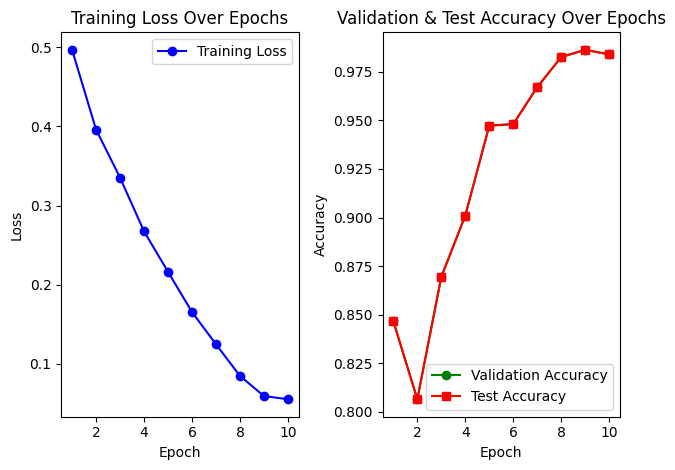

In [26]:
plt.figure()

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o', linestyle='-', color='g', label="Validation Accuracy")
plt.plot(range(1, num_epochs + 1), test_accuracies, marker='s', linestyle='-', color='r', label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation & Test Accuracy Over Epochs")
plt.legend()

plt.tight_layout()

# Save the plot
plot_path = os.path.join(output_dir, "training_validation_plot.png")
plt.savefig(plot_path)
print("Plot saved to:", plot_path)

plt.show()

Total Accuracy: 0.986277200548912


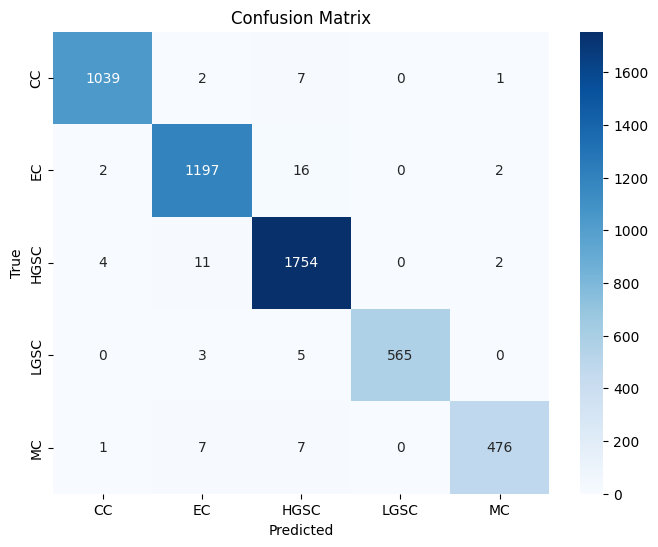

In [ ]:
state_dict = torch.load(model_save_path, map_location=device)
model.load_state_dict(state_dict)

model.eval()

all_preds = []
all_labels = []


with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print("Total Accuracy:", accuracy)

classes = ['CC', 'EC', 'HGSC', 'LGSC', 'MC']

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()